# Classification Model

This classification model is based on the tutorial at https://pytorch.org/tutorials/intermediate/speech_command_classification_with_torchaudio_tutorial.html and has been adapted with help from ChatGTP.

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys

import matplotlib.pyplot as plt
import IPython.display as ipd

from tqdm import tqdm

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()  # Initialize the TensorBoard writer


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [20]:
from collections import Counter
from sklearn.model_selection import train_test_split
import numpy as np
import os
from torch.utils.data import Dataset
import torchaudio

class CustomAudioDataset(Dataset):
    def __init__(self, root_dir, subset):
        self.root_dir = root_dir
        self.subset = subset

        self.filepaths = []
        self.labels = []

        # Load data from the directory
        for class_dir in os.listdir(root_dir):
            class_path = os.path.join(root_dir, class_dir)
            if os.path.isdir(class_path):
                for file in os.listdir(class_path):
                    self.filepaths.append(os.path.join(class_path, file))
                    self.labels.append(class_dir)

        # Convert to numpy arrays for compatibility with train_test_split
        self.filepaths = np.array(self.filepaths)
        self.labels = np.array(self.labels)

        # Count the number of instances per class
        label_counts = Counter(self.labels)
        print("Label distribution before filtering:", label_counts)

        # Filter out classes with fewer than 2 instances
        valid_labels = [label for label, count in label_counts.items() if count >= 2]
        valid_indices = [i for i, label in enumerate(self.labels) if label in valid_labels]
        self.filepaths = self.filepaths[valid_indices]
        self.labels = self.labels[valid_indices]

        # Re-check the class distribution
        label_counts = Counter(self.labels)
        print("Label distribution after filtering:", label_counts)

        # Split dataset
        train_files, temp_files, train_labels, temp_labels = train_test_split(
            self.filepaths, self.labels, test_size=0.2, random_state=42, stratify=self.labels)
        
        # Verify temp dataset
        temp_label_counts = Counter(temp_labels)
        print("Label distribution in temp split:", temp_label_counts)
        
        # Filter temp data if necessary
        valid_labels_temp = [label for label, count in temp_label_counts.items() if count > 1]
        temp_indices = [i for i, label in enumerate(temp_labels) if label in valid_labels_temp]
        temp_files = np.array(temp_files)[temp_indices]
        temp_labels = np.array(temp_labels)[temp_indices]

        # Re-check the class distribution in temp split
        temp_label_counts = Counter(temp_labels)
        print("Label distribution after filtering temp split:", temp_label_counts)

        val_files, test_files, val_labels, test_labels = train_test_split(
            temp_files, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels)

        if subset == 'training':
            self.filepaths, self.labels = train_files, train_labels
        elif subset == 'validation':
            self.filepaths, self.labels = val_files, val_labels
        elif subset == 'testing':
            self.filepaths, self.labels = test_files, test_labels

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        file_path = self.filepaths[idx]
        label = self.labels[idx]
        waveform, sample_rate = torchaudio.load(file_path)
        return waveform, sample_rate, label

# Create training, validation, and testing splits of the data
train_set = CustomAudioDataset(root_dir='/Users/loiskelly/Documents/GitHub/thesis/data/wav_files_10_CUT', subset='training')
val_set = CustomAudioDataset(root_dir='/Users/loiskelly/Documents/GitHub/thesis/data/wav_files_10_CUT', subset='validation')
test_set = CustomAudioDataset(root_dir='/Users/loiskelly/Documents/GitHub/thesis/data/wav_files_10_CUT', subset='testing')


Label distribution before filtering: Counter({'JohnColtrane': 680, 'JoeHenderson': 587, 'MilesDavis': 324, 'CharlieParker': 259, 'SonnyRollins': 242, 'FreddieHubbard': 216, 'WayneShorter': 189, 'DexterGordon': 180, 'WoodyShaw': 136, 'ChetBaker': 120, 'HankMobley': 106, 'BennyCarter': 71, 'BennyGoodman': 48, 'KaiWinding': 28, 'CurtisFuller': 22, 'DizzyGillespie': 19, 'LouisArmstrong': 18, 'KidOry': 9})
Label distribution after filtering: Counter({'JohnColtrane': 680, 'JoeHenderson': 587, 'MilesDavis': 324, 'CharlieParker': 259, 'SonnyRollins': 242, 'FreddieHubbard': 216, 'WayneShorter': 189, 'DexterGordon': 180, 'WoodyShaw': 136, 'ChetBaker': 120, 'HankMobley': 106, 'BennyCarter': 71, 'BennyGoodman': 48, 'KaiWinding': 28, 'CurtisFuller': 22, 'DizzyGillespie': 19, 'LouisArmstrong': 18, 'KidOry': 9})
Label distribution in temp split: Counter({'JohnColtrane': 136, 'JoeHenderson': 117, 'MilesDavis': 65, 'CharlieParker': 52, 'SonnyRollins': 48, 'FreddieHubbard': 43, 'WayneShorter': 38, 'Dext

In [21]:
waveform, sample_rate, label= train_set[0]


I need to split my 5 second audio folders into test and train 


Shape of waveform: torch.Size([1, 441000])
Sample rate of waveform: 44100


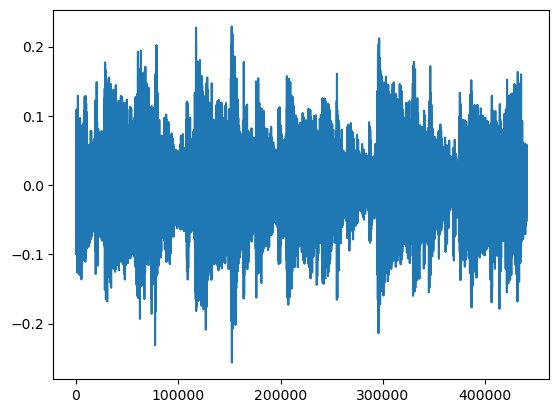

In [22]:
import wave 
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy());

In [23]:
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))
labels

['BennyCarter',
 'BennyGoodman',
 'CharlieParker',
 'ChetBaker',
 'CurtisFuller',
 'DexterGordon',
 'DizzyGillespie',
 'FreddieHubbard',
 'HankMobley',
 'JoeHenderson',
 'JohnColtrane',
 'KaiWinding',
 'KidOry',
 'LouisArmstrong',
 'MilesDavis',
 'SonnyRollins',
 'WayneShorter',
 'WoodyShaw']

In [24]:
len(labels)

18

In [25]:
waveform_first, *_ = train_set[0]
ipd.Audio(waveform_first.numpy(), rate=sample_rate)

waveform_second, *_ = train_set[1]
ipd.Audio(waveform_second.numpy(), rate=sample_rate)

In [26]:
new_sample_rate = 8000
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
transformed = transform(waveform)

ipd.Audio(transformed.numpy(), rate=new_sample_rate)

In [27]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]


word_start = "BennyGoodman"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

BennyGoodman --> tensor(1) --> BennyGoodman


In [28]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 256

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

In [29]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)


model = M5(n_input=transformed.shape[0], n_output=len(labels))
model.to(device)
print(model)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)

M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=18, bias=True)
)
Numbe

In [30]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10

In [31]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [32]:
def train(model, epoch, log_interval):
    model.train()
    correct = 0
    total_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)

        # Apply transform and model on the whole batch
        data = transform(data)
        output = model(data)

        loss = F.nll_loss(output.squeeze(), target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

        # Print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} "
                  f"({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

    # Calculate and store the average loss and accuracy
    train_losses.append(total_loss / len(train_loader))
    train_accuracies.append(100. * correct / len(train_loader.dataset))

 

In [33]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


best_loss = float('inf')  # Track the best validation loss

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def test(model, epoch):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)

            data = transform(data)
            output = model(data)

            test_loss += F.nll_loss(output.squeeze(), target, reduction='sum').item()  # sum up batch loss
            pred = get_likely_index(output)
            correct += number_of_correct(pred, target)

    # Calculate average test loss and accuracy
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)

    test_losses.append(test_loss)
    test_accuracies.append(accuracy)

    print(f"\nTest Epoch: {epoch}\tAverage Loss: {test_loss:.6f}\tAccuracy: {correct}/{len(test_loader.dataset)} "
          f"({accuracy:.2f}%)\n")


In [34]:
log_interval = 20
n_epoch = 40 

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []
# The transform needs to live on the same device as the model and the data.
transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        test(model, epoch)

        # Step the scheduler
        scheduler.step()

        # Log the learning rate
        current_lr = scheduler.get_last_lr()[0]
        writer.add_scalar('Learning Rate', current_lr, epoch)


# Let's plot the training loss versus the number of iteration.
# plt.plot(losses);
# plt.title("training loss");

  0%|          | 0/40 [00:00<?, ?it/s]

Train Epoch: 1 [0/2603 (0%)]	Loss: 3.108695

Test Epoch: 1	Average Loss: 2.903726	Accuracy: 60/326 (18.40%)

Train Epoch: 2 [0/2603 (0%)]	Loss: 1.923011

Test Epoch: 2	Average Loss: 2.388915	Accuracy: 109/326 (33.44%)

Train Epoch: 3 [0/2603 (0%)]	Loss: 1.561674

Test Epoch: 3	Average Loss: 2.143827	Accuracy: 102/326 (31.29%)

Train Epoch: 4 [0/2603 (0%)]	Loss: 1.359966

Test Epoch: 4	Average Loss: 1.700993	Accuracy: 163/326 (50.00%)

Train Epoch: 5 [0/2603 (0%)]	Loss: 1.146606

Test Epoch: 5	Average Loss: 2.799561	Accuracy: 106/326 (32.52%)

Train Epoch: 6 [0/2603 (0%)]	Loss: 0.870433

Test Epoch: 6	Average Loss: 1.466202	Accuracy: 187/326 (57.36%)

Train Epoch: 7 [0/2603 (0%)]	Loss: 0.969319

Test Epoch: 7	Average Loss: 1.703556	Accuracy: 172/326 (52.76%)

Train Epoch: 8 [0/2603 (0%)]	Loss: 0.756950

Test Epoch: 8	Average Loss: 1.182584	Accuracy: 210/326 (64.42%)

Train Epoch: 9 [0/2603 (0%)]	Loss: 0.620171

Test Epoch: 9	Average Loss: 1.223552	Accuracy: 189/326 (57.98%)

Train Epoch

  0%|          | 0/40 [10:11<?, ?it/s]


Test Epoch: 40	Average Loss: 0.288068	Accuracy: 293/326 (89.88%)



In [37]:
def predict(tensor):
    # Use the model to predict the label of the waveform
    tensor = tensor.to(device)
    tensor = transform(tensor)
    tensor = model(tensor.unsqueeze(0))
    tensor = get_likely_index(tensor)
    tensor = index_to_label(tensor.squeeze())
    return tensor


waveform, sample_rate, utterance, *_ = train_set[-1]
ipd.Audio(waveform.numpy(), rate=sample_rate)

print(f"Expected: {utterance}. Predicted: {predict(waveform)}.")

Expected: MilesDavis. Predicted: MilesDavis.


In [41]:
for i, (waveform, sample_rate, utterance, *_) in enumerate(test_set):
    output = predict(waveform)
    if output != utterance:
        ipd.Audio(waveform.numpy(), rate=sample_rate)
        print(f"Data point #{i}. Expected: {utterance}. Predicted: {output}.")
        break
else:
    print("All examples in this dataset were correctly classified!")
    print("In this case, let's just look at the last data point")
    ipd.Audio(waveform.numpy(), rate=sample_rate)
    print(f"Data point #{i}. Expected: {utterance}. Predicted: {output}.")

Data point #24. Expected: SonnyRollins. Predicted: DexterGordon.


In [42]:
# Path to the test audio file
test_file = '/Users/loiskelly/Documents/GitHub/thesis/unseendata/miles/Miles Davis - Milestones solo transcription.wav_6.wav'
# Load the audio file
waveform, sample_rate = torchaudio.load(test_file)

# Make a prediction
prediction = predict(waveform)

# Print the prediction
print(f"Predicted: {prediction}.")

# Play the audio
ipd.display(ipd.Audio(waveform.numpy(), rate=sample_rate))

Predicted: ChetBaker.


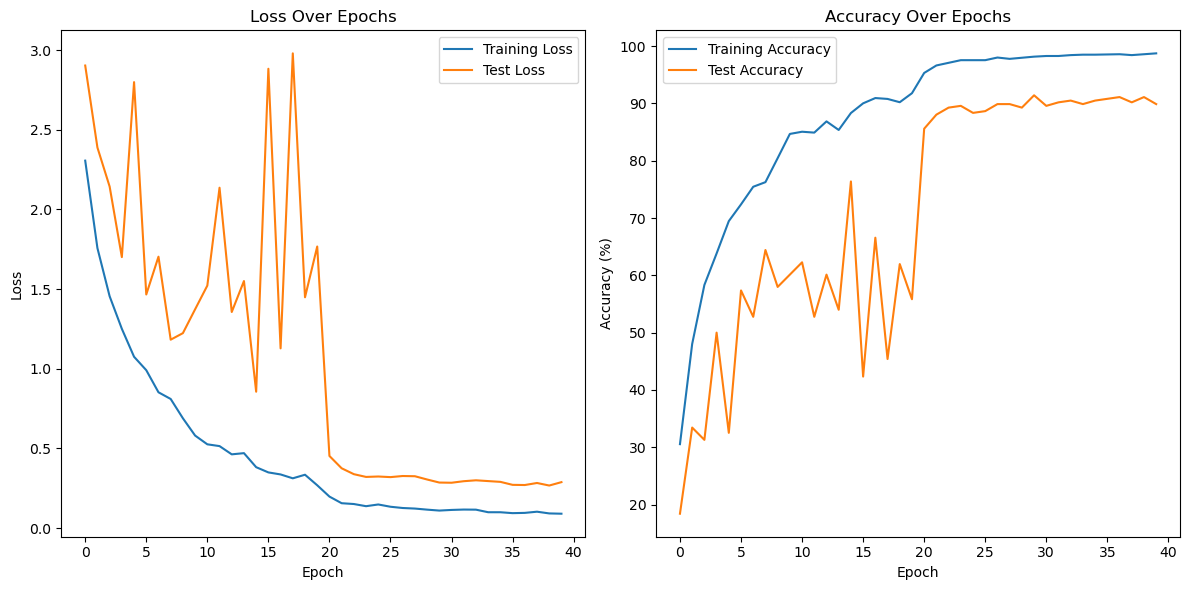

In [43]:
import matplotlib.pyplot as plt

# Plotting the loss graph
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

# Plotting the accuracy graph
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Training Accuracy")
plt.plot(test_accuracies, label="Test Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Over Epochs')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()
